## Домашняя работа #3.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе:
https://forms.gle/zemRsbegG9fQRVw76

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.

Материалы к домашке доступны по ссылке:
https://drive.google.com/drive/folders/1dNoAOMcrRyuf_3vS1LTPpdyrqYxgvPOy?usp=sharing



Большая домашка с увеличенным баллом и временем до дедлайна.
* Морфлогия.
* Фильтры габора.
* Цветовые гистрограммы.
* Гистограммы градиентов.


**Soft deadline: 25.03.2022 03:00:00 +0003 GMT**

**Hard deadline: 01.04.2022 03:00:00 +0003 GMT**

In [157]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path("/content/drive/MyDrive/homework3-materials")

In [159]:
import cv2
import numpy as np
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=kwargs.get('size', (10, 5)))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img, size=(10, 5)):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

@pyplot
def show_gray(img, size=(10, 5)):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()



# МОРФОЛОГИЯ

**1. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использованием морфологических операций. Результатом обработки должно бытьn изображение, в котором удален весь текст и оставлены только границы таблицы.

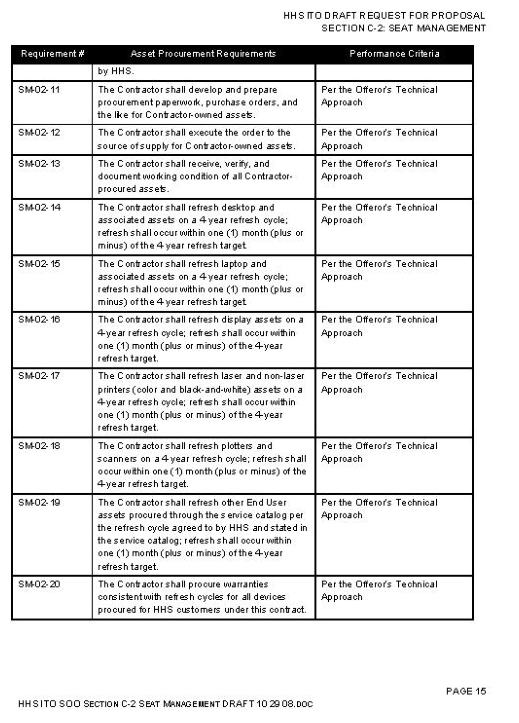

In [401]:
table = cv2.imread(str(sources_path / "table.jpg"), 0)
show_gray(table, size=(5, 10))

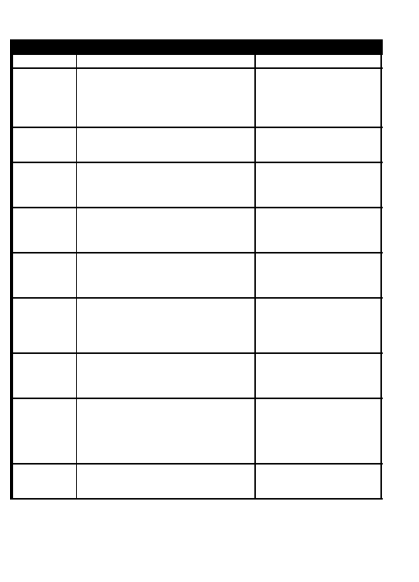

In [402]:
vertical = cv2.morphologyEx(table, cv2.MORPH_CLOSE, np.ones((16, 1), np.uint8))
horizontal = cv2.morphologyEx(table, cv2.MORPH_CLOSE, np.ones((2, 12), np.uint8))
img = ((cv2.bitwise_not(vertical) + cv2.bitwise_not(horizontal)) < 200).astype(np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((12, 12), np.uint8))
show_gray(img, size=(4, 8))

**2. (5 баллов)** Для изображения $circles.jpg$ реализуйте морфологический алгоритм для построения трех изображений, которые бы содержали соответственно:

* только частицы, касающиеся краев изображения, 

* только группы перекрывающихся частиц,

* только одиночные круглые частицы.

Посчитайте число частиц и групп на каждом изображении. Раскрастье отдельные компоненты с помощью функции. 

In [403]:
circles = cv2.imread(str(sources_path / "circles.png"), 0)
# Переводим в 0/1
ret, img = cv2.threshold(circles, 127, 255, cv2.THRESH_BINARY)
img_border = img.copy()
# Дeлаем рамку черной 
# Можно морфологией, но там не слишком аккуратно получается, так что сделаем руками 
img[:, :43] = img[:, 269:] = img[:16, :] = img[415:, :] = 0

kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

# Connected circles

kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (12, 12))
group_cross = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_cross)
group_cross = cv2.dilate(group_cross, kernel_ellips, iterations=1) & img

kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
connected = cv2.morphologyEx(group_cross, cv2.MORPH_OPEN, kernel_ellips)

# Separate circles
separate_circles = img - connected
separate_circles = cv2.morphologyEx(separate_circles, cv2.MORPH_OPEN, kernel_ellips, iterations=1)

# Broder circles
border_circles = img_border - connected
kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
separate_circles = cv2.morphologyEx(border_circles, cv2.MORPH_OPEN, kernel_ellips)

border_circles_x = cv2.morphologyEx(border_circles, cv2.MORPH_OPEN, kernel=np.ones((14, 7), dtype=np.uint8))
kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
border_circles_x = cv2.dilate(border_circles_x, kernel_ellips)

border_circles_y = cv2.morphologyEx(border_circles, cv2.MORPH_OPEN, kernel=np.ones((7, 16), dtype=np.uint8))
kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
border_circles_y = cv2.morphologyEx(border_circles_y, cv2.MORPH_OPEN, kernel_ellips)
kernel_ellips = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
border_circles_y = cv2.dilate(border_circles_y, kernel_ellips)

border_circles = border_circles_y | border_circles_x
border_circles[:, :45] = border_circles[:, 268:] = border_circles[:19, :] = border_circles[414:, :] = 0


In [404]:
def connected_component_label(img, return_counts=False):
    # Applying cv2.connectedComponents() 
    num_labels, labels = cv2.connectedComponents(img)

    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue == 0] = 0
    if return_counts:
        return num_labels

    return cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)


Number of components: 
Circles  : 115
Connected circles  : 64
Separate circles  : 83
Border circles  : 12


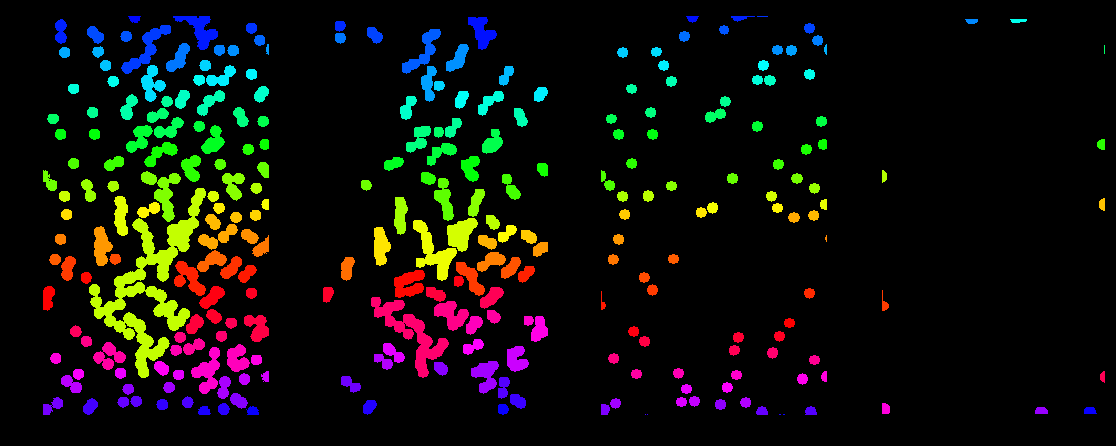

In [405]:
imgs = [img, connected, separate_circles, border_circles]
n_labels = ["Circles", "Connected circles", "Separate circles", "Border circles"]
# border_circles = cv2.erode(border_circles, np.ones((2, 2), dtype = np.uint8))

print("Number of components: ")
for name, img in zip(n_labels, imgs):
    img[:, :43] = img[:, 269:] = img[:16, :] = img[415:, :] = 0
    print(f"{name}", " :", connected_component_label(img, True))

res = np.hstack([connected_component_label(img) for img in imgs])
cv2_imshow(res)

**3. (5 баллов)** **Watershed**

* Возьмите изображения: *coins_1.jpg*, *coins_noize_1.jpg*
* Примените к ним алгоритм водораздела, чтобы посчитать монетки
* отсоритруйте монетки по размеру и у каждой моентки в центре впишите порядковое число

В сниппете кода содержится подсказка о том, какие функции стоит поприменять. 

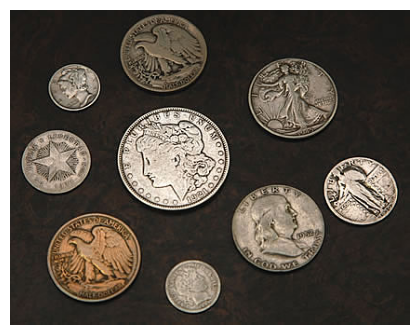

In [ ]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy
from scipy import ndimage as ndi
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label
from cv2 import pyrMeanShiftFiltering

coins_1 = cv2.imread(str(sources_path / "coins_1.jpg"))
show_bgr(coins_1, size=(4, 5))

In [ ]:
def coins_number(image):
    initial_image = image.copy()
    image = cv2.pyrMeanShiftFiltering(src=initial_image, sp=10, sr=50).mean(2) > 50

    distance = ndi.distance_transform_edt(image)
    max_coords = peak_local_max(distance, labels=image, min_distance=40)
    local_maxima = np.zeros_like(image, dtype=bool)
    local_maxima[tuple(max_coords.T)] = True

    markers = ndi.label(local_maxima)[0]
    labels = watershed(-distance, markers, mask=image)
    numbers, counts = np.unique(labels[labels != 0], return_counts=True)
    numbers = numbers[np.argsort(counts)[::-1]]

    for counter, number in enumerate(numbers):
        mask = np.zeros(image.shape, dtype="float")
        mask[labels == number] = 1
        x_center = int((mask.mean(1) * np.arange(mask.shape[0])).sum() / mask.mean(1).sum())
        y_center = int((mask.mean(0) * np.arange(mask.shape[1])).sum() / mask.mean(0).sum())

        cv2.putText(initial_image, str(counter + 1), (y_center - 10, x_center + 10), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (0, 255, 255), 2)

    return initial_image

((339, 430, 3), (426, 640, 3))

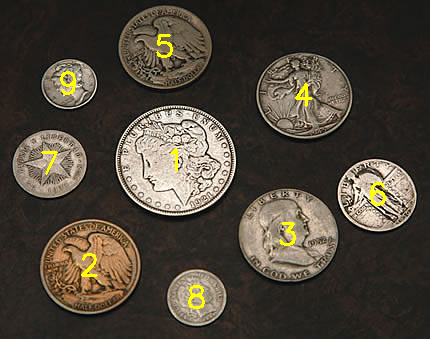

In [ ]:
coins_1 = cv2.imread(str(sources_path / "coins_1.jpg"))
cv2_imshow(coins_number(coins_1))

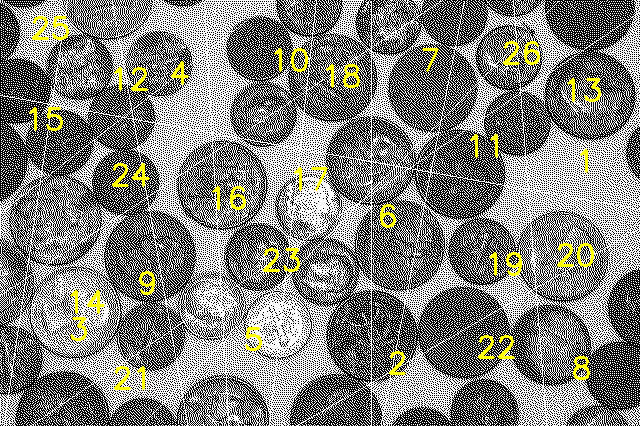

In [ ]:
coins_2 = cv2.imread(str(sources_path / "coins_noize_2.jpg"))
cv2_imshow(coins_number(coins_2))

# Фильтры габора

**4. (15 баллов)**  

Реализуйте функцию, которая построит банк фильтров Габора по входящим аргументам n, m. 
* n – число различных частот в дипазоне (0; max_freq]
* m - число различных напралений в диапазоне [0; Pi)

Продемонструйте, что предложенные фильтры более-менее плотно заполняют частотное просранство. Для этого переведите все фильтры в частотное пространство и отобразите все их одновременно на одной картинке. 

Реализуйте интерактивное demo в котром будут два слайдера, один отвечает за разные разные частоы, другой за разные направления. Выведите 3 изображения:
* Вид фильтра в пространстве изображений
* Вид Фильтра в частотном пространстве
* Результат применения фильтра к $lena.jpg$

In [397]:
def gabor_kernel(frequency, theta=0):
    """Return complex 2D Gabor filter kernel.
    Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
   """

    sigma_x, sigma_y, n_stds = 3, 3, 7

    ct = np.cos(theta)
    st = np.sin(theta)
    x0, y0 = 7, 7
    y, x = np.meshgrid(np.arange(-y0, y0 + 1),
                       np.arange(-x0, x0 + 1),
                       indexing='ij',
                       sparse=True)
    # Ritation
    rotx = x * ct + y * st
    roty = -x * st + y * ct

    g = np.empty(roty.shape, dtype=np.complex128)

    np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2) + 1j * (2 * np.pi * frequency * rotx),
           out=g)
    g *= 1 / (2 * np.pi * sigma_x * sigma_y)

    return g.real

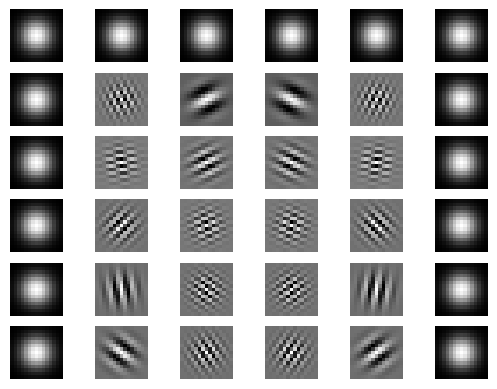

In [398]:
def filter_bank(n, m, max_freq=15):
    frequences = np.linspace(0.001, max_freq, n)
    thetas = np.linspace(0, 180, m) * np.pi / 180

    filter_bank = []

    for freq in frequences:
        main_theta = []
        for theta in thetas:
            gk = gabor_kernel(frequency=freq, theta=theta)
            main_theta.append(gk)
        filter_bank.append(main_theta)
    return np.array(filter_bank)


bank = filter_bank(6, 6)
fig, axis = plt.subplots(6, 6, sharex=True, sharey=True)

for i in range(6):
    for j in range(6):
        axis[i][j].imshow(bank[i][j], cmap='gray')
        axis[i][j].axis('off')

In [399]:
def make_spectrum(image):
    out = np.fft.fft2(image)
    out = np.fft.fftshift(out)
    out = np.log(1 + np.abs(out))
    return out

In [400]:
from skimage.filters import gabor, gabor_kernel
from ipywidgets import interact


@interact(theta=(0, 180, 1), freq=(0, 0.5, 0.005))
def anim_general_solution(theta=45, freq=0.05):
    # Filter
    gk = gabor_kernel(frequency=freq, theta=theta).real
    g_kernel = cv2.resize(gk, (512, 512), interpolation=cv2.INTER_CUBIC)

    # Lena
    lena = cv2.imread('/content/lena.jpg', 0)
    filtered_img = cv2.filter2D(lena, cv2.CV_8UC3, gk)
    filt_lena, _ = gabor(lena, frequency=freq, theta=theta)

    # Filter freq
    resize_s = cv2.resize(make_spectrum(gk), (512, 512), interpolation=cv2.INTER_CUBIC)

    res = [g_kernel, resize_s, filt_lena]
    fig, axis = plt.subplots(1, 3, figsize=(15, 15))
    for i, im in enumerate(res):
        axis[i].imshow(im, cmap='gray')
        axis[i].axis('off')


interactive(children=(IntSlider(value=45, description='theta', max=180), FloatSlider(value=0.05, description='…

# Цветовые гистрограммы.

**5. (15 баллов)**

Надо реализовать функцию, которая принимет на вход:

* список дескрипторов (**id**, и сам дескриптор) 
* количество максимально похожих для вывода **n**
* функцию сранения дескрипторов

и отдает **n** пар **id** максимально похожих изображений.

Посмотрите на изображения в папке *Corel*. Посчитайте гистограммы изображений. Выведите на экран 20 пар изображений с максимально похожими гистограммами, которые получаются для лучшей комбинации. В этом задании надо попробовать:
* различные цветовые пространства (RGB, HSV, CIELab)
* различные способы разбиения на бины (разное количество для каждой характеристики, joint_vs_marginal)
* различные метрики сравнения $L_2$, $\chi^2$, пересечение гистограм

Постройте сводную таблицу-отчет в которою впишите, сколько похожих пар получилось для каждого эксперимента. Проведите не менее 8 экспериментов и напишите какие-нибудь выводы

In [ ]:
!unzip "/content/drive/MyDrive/homework3-materials/Corel-10k.zip"

In [385]:
from skimage.util import dtype
import os
import itertools

path = "/content/Corel100类库/"
data = []
count = 0
for name in os.listdir(path)[:1000]:
    img = cv2.imread(path + name)
    if img is not None:
      data.append((name, img))

data = np.array(data, dtype=object)

In [386]:
from itertools import combinations
import cv2
import matplotlib.pyplot as plt
import numpy as np


class CompareImage:
    def __init__(self, data, metric='xi2', color='RGB', hist_type='joint', n_bin=25, n=20):
        self.n = n
        self.n_bin = n_bin
        self.hist_type = hist_type
        self.color = color
        self.metric = metric
        self.data = data

    def calc_hist(self, image):
        """
        На вход картинка
        На выход гистограмма
        """
        color_map = {'RGB': cv2.COLOR_BGR2RGB, 'HSV': cv2.COLOR_BGR2HSV, 'CIELab': cv2.COLOR_BGR2Lab}
        image = cv2.cvtColor(image, color_map[self.color])

        if self.hist_type == 'joint':
            hist = cv2.calcHist(image, [0, 1, 2], None, [256 // self.n_bin] * 3, [0, 256] * 3)
            cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        else:
            hist = np.hstack([cv2.calcHist(image, [i], None, [256 // self.n_bin], [0, 255]) for i in range(3)])
            cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        return hist

    def calc_dist(self, img1, img2):
        """
        На вход две картинки
        Выход расстояние между ними
        """
        h1, h2 = self.calc_hist(img1), self.calc_hist(img2)

        if self.metric == 'l2':
            dist = cv2.norm(h1, h2, cv2.NORM_L2)
        else:
            dist = cv2.compareHist(h1, h2, cv2.HISTCMP_CHISQR_ALT)
        return dist

    def matching_pairs(self):

        pairs = combinations(range(len(self.data)), 2)
        dists = []
        for i, j in pairs:
            img1, img2 = self.data[i][1], self.data[j][1]
            dists.append((self.calc_dist(img1, img2), i, j))

        dists = [(data[i], data[j]) for _, i, j in sorted(dists)]
        return dists[:self.n]

    def show_result(self):
        pairs = self.matching_pairs()
        for p in pairs:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.set_title(f'{p[0][0]}')
            ax1.axis('Off')
            ax1.imshow(p[0][1][:, :, ::-1])
            ax2.set_title(f'{p[1][0]}')
            ax2.axis('Off')
            ax2.imshow(p[1][1][:, :, ::-1])
        plt.show()



In [387]:
CompareImage(data).show_result()

Output hidden; open in https://colab.research.google.com to view.

In [388]:
CompareImage(data, 'l2', 'HSV', "marginal").show_result()

Output hidden; open in https://colab.research.google.com to view.

In [395]:
CompareImage(data = data, metric='xi2', color='RGB', hist_type='joint', n_bin=25, n=20).show_result()

Output hidden; open in https://colab.research.google.com to view.

Выводы: слишком большое количество бинов - это плохо, картинки подбираются почти рандомно. Лучше работать в пространстве HSV. Есть вопросы к функции cv2.Hist, там чтобы получить три гистрограммы по трем каналам необходимо сумировать трехмерный тензор не понятно в каком порядке (выяснила эксперементальным путем). 

# Гистограмма градиентов

**6. (10 баллов)**

Реализуйте функцию вычисления $HOG$ дескриптора для изображения, которая принимает на вход размер сетки. Визуализируйте полученный дескриптор на изображении *susi_example.jpg* с сетками размером 10x8 и 5x4. Просканируйте скользящим окном изображение *susi_gallery.jpg* и подсветите все области, дексриптор которых поход на дескриптор *susi_example.jpg*. В идеальном случае мы должны получить 3 изображения, для которых надо подобрать порог похожести:
* Та самая вырезанная сушина.
* Все суши с креветкой.
* Все суши, которые визуально похожи на суши с креветкой. 

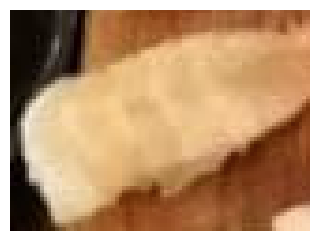

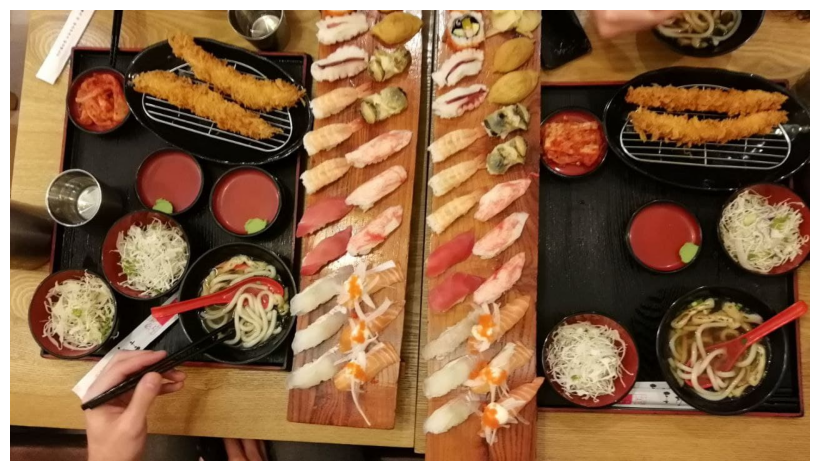

In [ ]:
susi_example = cv2.imread(str(sources_path / "susi_example.jpg"))
show_bgr(susi_example, size=(3, 4))
susi_gallery = cv2.imread(str(sources_path / "susi_gallery.jpg"))
show_bgr(susi_gallery, size=(8, 16))

In [ ]:
n_row, n_col, _ = susi_example.shape
cell_size = (10, 8)
block_size = (5, 4)

hog = cv2.HOGDescriptor(
    _winSize=(n_col // cell_size[1] * cell_size[1], n_row // cell_size[0] * cell_size[0]),
    _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0]),
    _blockStride=(cell_size[1], cell_size[0]),
    _cellSize=(cell_size[1], cell_size[0]),
    _nbins=8)

ex_hist = hog.compute(susi_example)

In [ ]:
g_row, g_col, _ = susi_gallery.shape
res = []
for row in range(0, g_row - n_row, 8):
    for col in range(0, g_col - n_col, 8):
        tmp = susi_gallery[row : row + n_row, col : col + n_col]
        tmp_hist = hog.compute(tmp)
        diff = np.sum(np.abs(ex_hist - tmp_hist))
        res.append((diff, col, row))
res.sort()

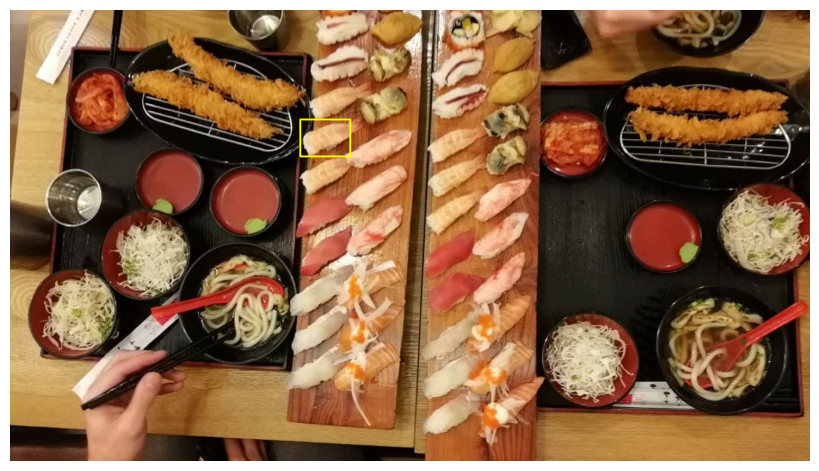

In [ ]:
img1 = susi_gallery.copy()
_, i, j = res[0]
img1 = cv2.rectangle(img1, (i, j), (i + 80, j + 59), (0,255,255), 2)
show_bgr(img1, size=(8, 16))

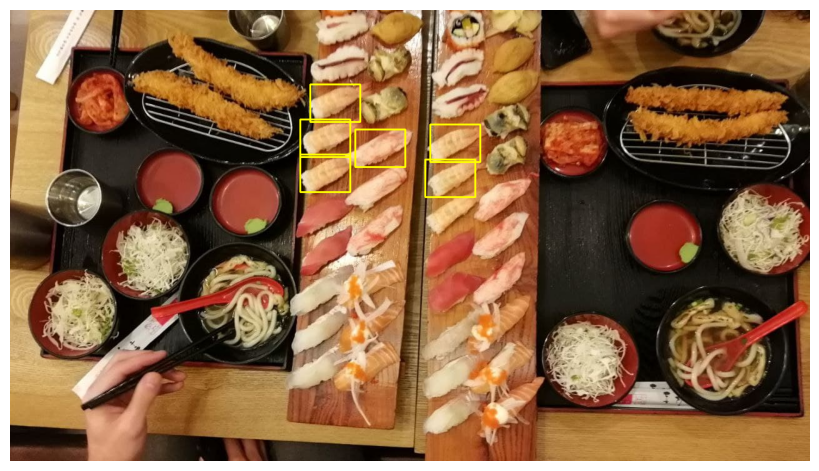

In [ ]:
# Все суши с креветкой.
img2 = susi_gallery.copy()
visited = []

for _, i, j in res[:10]:
    checked = True
    for _i, _j in visited: 
      if np.abs(_i - i) < 40 and np.abs(_j - j) < 40:
            checked = False
            continue
    if checked:

        img1 = cv2.rectangle(img2, (i, j), (i + 80, j + 60), (0,255,255), 2)
        visited.append((i, j))
show_bgr(img2, size=(8, 16))

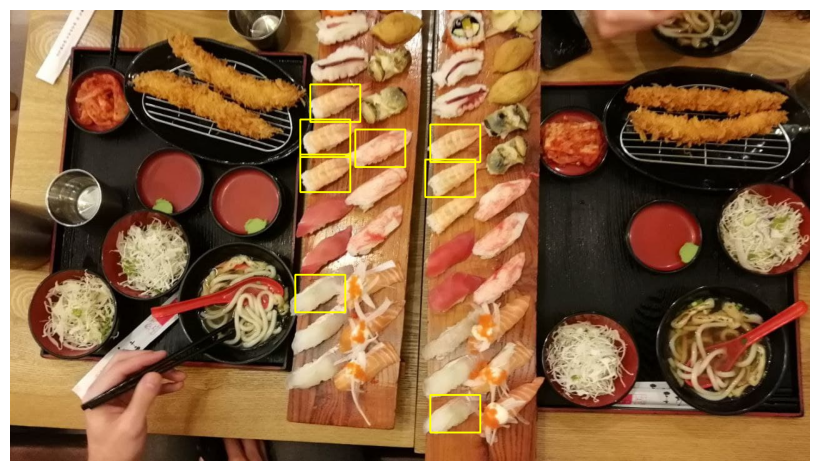

In [ ]:
# Все суши, которые визуально похожи на суши с креветкой.
img3 = susi_gallery.copy()
visited = []

for _, i, j in res[:20]:
    checked = True
    for _i, _j in visited: 
      if np.abs(_i - i) < 40 and np.abs(_j - j) < 40:
            checked = False
            continue
    if checked:

        img1 = cv2.rectangle(img3, (i, j), (i + 80, j + 60), (0,255,255), 2)
        visited.append((i, j))
show_bgr(img3, size=(8, 16))